sar01
sar03
sar04
sar05
sar06
sar07
sar08
sar09
sar10
sar11
sar12
sar13
sar14
sar15
sar16
sar17
sar18
sar19
sar20
sar21
sar22
sar23
sar24
sar25
sar26
sar27
sar28
sar29
sar30
sar31
DFR_Average
0.31401896476745605
DFR
0.10954022407531738


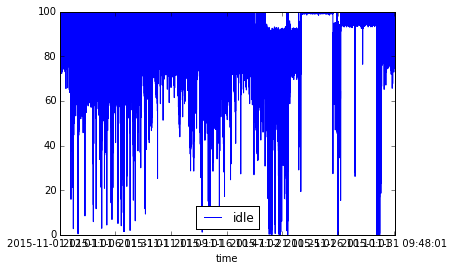

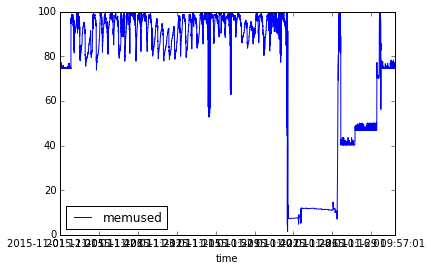

In [25]:
import re
import pandas as pd
import os
import mmap
import itertools
import numpy as np
import datetime
from os import listdir
from os.path import isfile, join
from sar import PART_CPU, PART_MEM, PART_SWP, PART_IO, \
    PATTERN_CPU, PATTERN_MEM, PATTERN_SWP, PATTERN_IO, PATTERN_RESTART, \
    FIELDS_CPU, FIELD_PAIRS_CPU, FIELDS_MEM, FIELD_PAIRS_MEM, FIELDS_SWP, \
    FIELD_PAIRS_SWP, FIELDS_IO, FIELD_PAIRS_IO

import matplotlib.pyplot as plt
%matplotlib inline  

def _split_file(self, data=''):
        '''
        Splits SAR output or SAR output file (in ASCII format) in order to
        extract info we need for it, in the format we want.
            :param data: Input data instead of file
            :type data: str.
            :return: ``List``-style of SAR file sections separated by
                the type of info they contain (SAR file sections) without
                parsing what is exactly what at this point
        '''

        # Filename passed checks through __init__
        if ((self and os.access(self, os.R_OK))
                or data != ''):

            fhandle = None

            if (data == ''):
                try:
                    fhandle = os.open(self, os.O_RDONLY)
                except OSError:
                    print(("Couldn't open file %s" % (self.__filename)))
                    fhandle = None

            if (fhandle or data != ''):

                datalength = 0
                dataprot = mmap.PROT_READ

                if (data != ''):
                    fhandle = -1
                    datalength = len(data)
                    dataprot = mmap.PROT_READ | mmap.PROT_WRITE

                try:
                    sarmap = mmap.mmap(
                        fhandle, length=datalength, prot=dataprot
                    )
                    if (data != ''):

                        sarmap.write(data)
                        sarmap.flush()
                        sarmap.seek(0, os.SEEK_SET)

                except (TypeError, IndexError):
                    if (data == ''):
                        os.close(fhandle)
                    traceback.print_exc()
                    #sys.exit(-1)
                    return False

                # Here we'll store chunks of SAR file, unparsed
                searchunks = []
                oldchunkpos = 0
               
                dlpos = sarmap.find(b"\n\n", 0)
                size = 0

                if (data == ''):
                    # We can do mmap.size() only on read-only mmaps
                    size = sarmap.size()
                else:
                    # Otherwise, if data was passed to us,
                    # we measure its length
                    len(data)

                #oldchunkpos = dlpos

                while (dlpos > -1):  # mmap.find() returns -1 on failure.

                    tempchunk = sarmap.read(dlpos - oldchunkpos)
                    searchunks.append(tempchunk.strip())

                    # We remember position, add 2 for 2 DD's
                    # (newspaces in production). We have to remember
                    # relative value
                    oldchunkpos += (dlpos - oldchunkpos) + 2

                    # We position to new place, to be behind \n\n
                    # we've looked for.
                    try:
                        sarmap.seek(2, os.SEEK_CUR)
                    except ValueError:
                        print(("Out of bounds (%s)!\n" % (sarmap.tell())))
                    # Now we repeat find.
                    dlpos = sarmap.find(b"\n\n")

                # If it wasn't the end of file, we want last piece of it
                if (oldchunkpos < size):
                    tempchunk = sarmap[(oldchunkpos):]
                    searchunks.append(tempchunk.strip())

                sarmap.close()

            if (fhandle != -1):
                os.close(fhandle)

            if (searchunks):
                return searchunks
            else:
                return False

        return False
    
def get_values(s, di):
    #print(s)
    s=s.split()
    df={}
    if s[0]=='Average:':
        df['time']=s[0]
        for k, v in di.items():
            df[k]=s[(int(v)-1)]
    else:
        df['time']=' '.join(s[0:1])
        
        for k, v in di.items():
            #print (k)
            #print (v)
            pattern_re = re.compile(k)
            if (pattern_re.search(s[v])):
                df[k]=np.nan
            else:
                df[k]=s[v]
    return (df)

def data_ind(part_parts, FIELDS_CPU):
    return_dict={}
    counter=0
    for piece in part_parts:
            for colname in FIELDS_CPU:
                pattern_re = re.compile(colname)
                if (pattern_re.search(piece)):
                    return_dict[colname.replace("%","").replace("\\","")] = counter
                    break
            counter += 1
    return return_dict

def get_data(S):
    cpu_pattern = re.compile('.*CPU.*(usr|user).*nice.*sys.*')
    mem_pattern = re.compile(PATTERN_MEM)
    swp_pattern = re.compile(PATTERN_SWP)
    io_pattern = re.compile(PATTERN_IO)
    restart_pattern = re.compile(PATTERN_RESTART)
    di={}
    dm={}
    FIELDS_CPU=['CPU','\\%usr', '\\%nice', '\\%sys', '\\%iowait', '\\%idle']
    CPU=list()
    MEM=list()
    for k in range(len(S)):

        D=(S[k].decode().split('\n'))
        part=D[0]
        if (cpu_pattern.search(part)):
            if len(di)==0:
                part_parts = part.split() 
                di=data_ind(part_parts, FIELDS_CPU)
            CPUn=list(map(get_values, D, itertools.repeat(di)))
            CPU.extend(CPUn)
        elif (mem_pattern.search(part)):
            if len(dm)==0:
                part_parts = part.split() 
                dm=data_ind(part_parts, FIELDS_MEM)
            MEMn=list(map(get_values, D, itertools.repeat(dm)))
            MEM.extend(MEMn)
            
        
    return (CPU, MEM)
#import date
mypath='/Users/annachystiakova/Documents/fs001/sars/'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
pattern_res = re.compile('sar\\d{2}')
DFR=pd.DataFrame()
DMR=pd.DataFrame()
for o in onlyfiles:
    if (pattern_res.fullmatch(o)):
        sarfile=join(mypath,o)
        S=_split_file(sarfile)
        FF, MEM=get_data(S)
        DF=pd.DataFrame(FF)
        DM=pd.DataFrame(MEM)
        d=datetime.date.today()
        #d=datetime(o)
        DF.time=DF.time.apply(lambda x: ' '.join(['-'.join([str(d.year), str(d.month), sarfile.replace(mypath,'').replace('sar','')]),x]))
        DM.time=DM.time.apply(lambda x: ' '.join(['-'.join([str(d.year), str(d.month), sarfile.replace(mypath,'').replace('sar','')]),x]))
        #DF = DF.set_index('time')
        DF=DF.dropna()
        #DF=DF.reindex()

        #DM = DM.set_index('time')
        DM=DM.dropna()
        #DM=DM.reindex()
        DFR=DFR.append(DF, ignore_index=True)
        DMR=DMR.append(DM, ignore_index=True)
        print (o)

import time
start = time.time()


DFR['idle'] = DFR['idle'].apply(float) 
DFR = DFR.set_index('time')
l='Average:'
DFR_Average=DFR.loc[DFR.index.map(lambda v: True if l in v else False)]
print ("DFR_Average")
end = time.time()
print (end - start)

DFR=DFR.loc[DFR.index.map(lambda v: False if l in v else True)]
#DFR_Average=DFR[DFR.index.apply(lambda v: True if l in v else False)]
#DFR=DFR[DFR.time.apply(lambda v: False if l in v else True)]

#DFR.index=pd.DatetimeIndex(DFR.index)
print ('DFR')
print ( time.time()-end)
#DFR = DFR.set_index('time')
pd.DataFrame(DFR.idle).plot()

DMR['memused'] = DMR['memused'].apply(float) 
DMR_Average=DMR[DMR.time.apply(lambda v: True if l in v else False)]
DMR=DMR[DMR.time.apply(lambda v: False if l in v else True)]

#DMR.time=pd.DatetimeIndex(DMR.time)
DMR = DMR.set_index('time')
pd.DataFrame(DMR.memused).plot()




In [17]:
#DFR.where(DFR.index.map(lambda v: True if l in v else False)[:,None])
#DFR.loc[DFR.index.map(lambda v: True if l in v else False)]
#len(DFR.index.map(lambda v: True if l in v else False))
#?pd.DataFrame.filter
#l='Average:'
#DFR_Average=DFR.loc[DFR.index.map(lambda v: True if l in v else False)]
#DFR.index=pd.DatetimeIndex(DFR.index)
#DFR[300879:]
DFR_Average1=DFR_Average.reset_index()
g=DFR_Average1.groupby(['CPU','time'])['idle'].sum()
g.loc['all']#.plot()

time
2015-11-01 Average:     98.74
2015-11-03 Average:     95.50
2015-11-04 Average:     96.39
2015-11-05 Average:     95.83
2015-11-06 Average:     95.44
2015-11-07 Average:     95.01
2015-11-08 Average:     96.15
2015-11-09 Average:     97.00
2015-11-10 Average:     97.38
2015-11-11 Average:     97.85
2015-11-12 Average:     97.59
2015-11-13 Average:     97.04
2015-11-14 Average:     96.70
2015-11-15 Average:     96.26
2015-11-16 Average:     96.40
2015-11-17 Average:     97.23
2015-11-18 Average:     97.88
2015-11-19 Average:     93.38
2015-11-20 Average:     85.73
2015-11-21 Average:     78.89
2015-11-22 Average:    164.12
2015-11-23 Average:     89.26
2015-11-24 Average:     99.56
2015-11-25 Average:     99.55
2015-11-26 Average:     88.54
2015-11-27 Average:     95.47
2015-11-28 Average:     99.40
2015-11-29 Average:     99.47
2015-11-30 Average:     89.81
2015-11-31 Average:     98.73
Name: idle, dtype: float64

                    kbbuffers kbcached kbmemfree kbmemused  memused
time                                                               
2015-11-01 12:01:01    387944  8896228   8296432  24320612    74.56
2015-11-01 12:02:01    387944  8896236   8298844  24318200    74.56
2015-11-01 12:03:01    387944  8896240   8298476  24318568    74.56
2015-11-01 12:04:01    387944  8896244   8297796  24319248    74.56
2015-11-01 12:05:01    387944  8896248   8287952  24329092    74.59


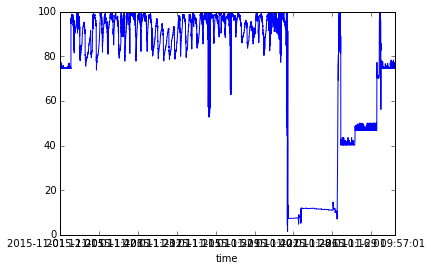

In [24]:
print(DMR.head())
DMR['memused'].plot()
#import matplotlib.pyplot as plt
#%matplotlib inline
#DFR['idle'] = DFR['idle'].apply(float) 
#pd.DataFrame(DFR.idle).plot()

In [221]:
def get_values(s, di):
    s=s.split()
    fd=[' '.join(s[0:1])]
    df={}
    df['time']=' '.join(s[0:1])
    for K in di.keys():
        pattern_re = re.compile(K)
        if (pattern_re.search(s[di[K]])):
            df[K]=np.nan
        else:
            df[K]=s[di[K]]
    return (df)
di={}
if len(di)==0:
                part_parts = D[0].split() 
                di=data_ind(part_parts, FIELDS_CPU)
                dv=list(di.values())
                    #dk=['time','idle','nice','iowait','usr','sys','cpu']
                #dk=['time','usr','iowait','nice','idle','sys','cpu']
                dk=['time']+(list(di.keys()))
FF=list(map(get_values, D, itertools.repeat(di)))

{'iowait': 6, 'sys': 5, 'idle': 11, 'nice': 4, '(usr|user)': 3}


In [247]:
#DF=pd.DataFrame(FF)
#DF.head()
DF.time=DF.time.apply(lambda x: ' '.join(['-'.join([str(d.year), str(d.month), sarfile.replace(mypath,'').replace('sar','')]),x]))

In [248]:
#import datetime
#time.ctime()
#d=datetime.date.today()
#'-'.join([str(d.year), str(d.month), sarfile.replace(mypath,'').replace('sar','')])
DF.head()

,(usr|user),idle,iowait,nice,sys,time
0,NaN,NaN,NaN,NaN,NaN,2015-10-22 10:23:01
1,23.42,33.64,0.03,33.38,8.15,2015-10-22 10:24:01
2,20.61,33.45,0.02,35.88,8.34,2015-10-22 10:24:01
3,19.22,32.92,0.00,37.94,8.66,2015-10-22 10:24:01
4,22.21,32.52,0.17,35.39,8.31,2015-10-22 10:24:01


In [36]:
cpu_pattern = re.compile('.*CPU.*(usr|user).*nice.*sys.*')
mem_pattern = re.compile(PATTERN_MEM)
swp_pattern = re.compile(PATTERN_SWP)
io_pattern = re.compile(PATTERN_IO)
restart_pattern = re.compile(PATTERN_RESTART)
cpuD=[]
memD=[]
D_cpu=pd.DataFrame()
D_av_cpu=pd.DataFrame()
D_mem=pd.DataFrame()
D_av_mem=pd.DataFrame()
di={}
dm={}
FIELDS_CPU=['CPU','\\%(usr|user)', '\\%nice', '\\%sys', '\\%iowait', '\\%idle']

#for k in range(len(S)):
        #print(k)
        #print(D_cpu.shape)
k=32
D=(S[k].decode().split('\n'))
part=D[0]
        #for part in D: 
if (cpu_pattern.search(part)):
    print(part)
    if len(di)==0:
        part_parts = part.split() 
        di=data_ind(part_parts, FIELDS_CPU)
        dv=list(di.values())
                #dk=['time','idle','nice','iowait','usr','sys','cpu']
        dk=['time','usr','iowait','nice','idle','sys','cpu']
    print (len(D))
    
    for d in D:
        if d.split()[0]=='Average:':
            G=get_values_av(d.split(), dv, dk[1:])
            if D_av_cpu.shape[0]==0:
                D_av_cpu=pd.DataFrame([G], columns=dk)
            else:
                D_av_cpu=pd.DataFrame([G], columns=dk)
        else:
            G=get_values(d.split(), dv, dk[1:])
            if D_cpu.shape[0]==0 and G:
                D_cpu=pd.DataFrame([G], columns=dk)
            elif G:
                D_cpu=D_cpu.append(pd.DataFrame([G], columns=dk), ignore_index=True)
    print (D_cpu.shape)
                #continue 
                
elif (mem_pattern.search(part)):
    if len(dm)==0:
        part_parts = part.split() 
        dm=data_ind(part_parts, FIELDS_MEM)
        dv=list(dm.values())
                    #dk=['time','kbbuffers', 'kbcached', 'kbmemfree', 'memused', 'kbmemused']
        dk=['time','kbcached',  'kbmemused',  'memused','kbmemfree','kbbuffers']
                    #kbcached	kbmemused	%memused	kbmemfree	kbbuffers
    for d in D:
        if d.split()[0]=='Average:':
            G=get_values_av(d.split(), dv, dk[1:])
            if D_av_mem.shape[0]==0:
                D_av_mem=pd.DataFrame([G], columns=dk)
            else:
                D_av_mem=pd.DataFrame([G], columns=dk)
        else:
            G=get_values(d.split(), dv, dk[1:])
            if D_mem.shape[0]==0 and G:
                D_mem=pd.DataFrame([G], columns=dk)
            elif G:
                D_mem=D_mem.append(pd.DataFrame([G], columns=dk), ignore_index=True)

10:23:01 AM     CPU      %usr     %nice      %sys   %iowait    %steal      %irq     %soft    %guest     %idle
{'\\%(usr|user)': 3, '\\%nice': 4, 'CPU': 2, '\\%iowait': 6, '\\%sys': 5, '\\%idle': 11}
302
(302, 7)


In [123]:
#D_mem1=D_mem
#print(D_mem.head())
#print(D_cpu.head())
D

['10:23:01 AM     CPU      %usr     %nice      %sys   %iowait    %steal      %irq     %soft    %guest     %idle',
 '10:24:01 AM     all     23.42     33.38      8.15      0.03      0.35      0.00      1.03      0.00     33.64',
 '10:24:01 AM       0     20.61     35.88      8.34      0.02      0.37      0.00      1.33      0.00     33.45',
 '10:24:01 AM       1     19.22     37.94      8.66      0.00      0.35      0.00      0.92      0.00     32.92',
 '10:24:01 AM       2     22.21     35.39      8.31      0.17      0.35      0.00      1.05      0.00     32.52',
 '10:24:01 AM       3     21.03     33.23      8.35      0.02      0.37      0.00      1.02      0.00     35.98',
 '10:24:01 AM       4     36.71     25.56      6.77      0.02      0.29      0.00      0.74      0.00     29.91',
 '10:24:01 AM       5     20.40     32.39      8.50      0.00      0.39      0.00      1.06      0.00     37.25',
 '10:25:01 AM     all     21.65     34.53      9.90      0.00      0.58      0.00      1

In [25]:
cpu_pattern = re.compile('.*CPU.*(usr|user).*nice.*sys.*')
FIELDS_CPU=['CPU','\\%(usr|user)', '\\%nice', '\\%sys', '\\%iowait', '\\%idle']
di ={}
D_cpu=pd.DataFrame()
for part in D: 
            if (cpu_pattern.search(part)):
                #print(part)
                #if (cpu_usage == ''):
                #    cpu_usage = D
                #    try:
                #        first_line = part.split("\n")[0]
                #    except IndexError:
                #        first_line = part
                #else:
                #    cpu_usage.extend(D) #+= "\n" + part
                #if len(cpuD)==0:
                #    cpuD=[k]
                #else:
                #    cpuD.append(k)
                if len(di)==0:
                    part_parts = part.split() 
                    di=data_ind(part_parts, FIELDS_CPU)
                    dv=list(di.values())
                    dk=['time','idle','nice','iowait','usr','sys','cpu']
                for d in D:
                    if d.split()[0]=='Average:':
                        G=get_values_av(d.split(), dv, dk[1:])
                        if D_av_cpu.shape[0]==0:
                            D_av_cpu=pd.DataFrame([G], columns=dk)
                        else:
                            D_av_cpu=pd.DataFrame([G], columns=dk)
                    else:
                        G=get_values(d.split(), dv, dk[1:])
                        print(G)
                        if D_cpu.shape[0]==0 and G:
                            D_cpu=pd.DataFrame([G], columns=dk)
                        elif G:
                            D_cpu=D_cpu.append(pd.DataFrame([G], columns=dk), ignore_index=True)

{'\\%(usr|user)': 3, '\\%iowait': 6, '\\%nice': 4, '\\%idle': 11, '\\%sys': 5, 'CPU': 2}
['12:00:01', '%usr', '%iowait', '%nice', '%idle', '%sys', 'CPU']
['12:01:01', '19.04', '1.46', '14.02', '54.90', '10.40', 'all']
['12:01:01', '27.99', '0.81', '10.98', '45.26', '14.00', '0']
['12:01:01', '20.28', '1.12', '12.65', '53.58', '12.35', '1']
['12:01:01', '17.52', '1.47', '11.60', '59.42', '9.95', '2']
['12:01:01', '15.36', '1.62', '15.66', '57.48', '9.86', '3']
['12:01:01', '15.29', '2.75', '17.94', '56.54', '7.44', '4']
['12:01:01', '17.91', '1.02', '15.21', '56.99', '8.83', '5']
['12:02:01', '0.18', '0.01', '16.44', '83.03', '0.31', 'all']
['12:02:01', '0.43', '0.05', '8.71', '90.44', '0.35', '0']
['12:02:01', '0.25', '0.03', '11.27', '88.13', '0.32', '1']
['12:02:01', '0.12', '0.02', '17.39', '82.06', '0.42', '2']
['12:02:01', '0.10', '0.00', '20.38', '79.25', '0.23', '3']
['12:02:01', '0.08', '0.00', '21.00', '78.62', '0.25', '4']
['12:02:01', '0.08', '0.00', '19.91', '79.70', '0.30'

In [357]:
D_mem['kbcached'] = D_mem['kbcached'].apply(int) 
D_mem['kbbuffers'] = D_mem['kbbuffers'].apply(int) 
D_mem['kbmemfree'] = D_mem['kbmemfree'].apply(int) 
D_mem['kbmemused'] = D_mem['kbmemused'].apply(int)
D_mem['cached']=100*D_mem['kbcached']/(D_mem['kbcached']+D_mem['kbbuffers']+D_mem['kbmemfree'])

In [370]:
self=sarfile
#self='/Users/annachystiakova/Documents/fs001/sar21'
print(self)
os.access(self, os.R_OK)

/Users/annachystiakova/Documents/fs002/sar21


True

,idle,nice,iowait,usr,sys,cpu,load
time,,,,,,,
2015-10-21 12:01:01,62.66,0.00,0.90,24.69,11.48,all,37.34
2015-10-21 12:02:01,93.73,0.00,0.01,4.94,1.30,all,6.27
2015-10-21 12:03:01,84.78,0.00,0.02,11.39,3.80,all,15.22
2015-10-21 12:04:01,79.70,0.00,0.02,11.97,7.99,all,20.30
2015-10-21 12:05:02,94.38,0.00,0.01,1.31,4.08,all,5.62


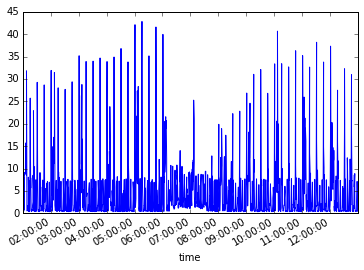

In [348]:
D_cpu.time=pd.DatetimeIndex(D_cpu.time)
D_cpu.head()#['idle']
D_cpu['idle'] = D_cpu['idle'].apply(float) 
D_cpu['load']=100-D_cpu['idle']
cpu_all=D_cpu[D_cpu.cpu=='all']
cpu_all = cpu_all.set_index('time')
pd.Series(cpu_all.load).plot()
cpu_all.head()

In [278]:
(1056692+31560340)/1024/1024


31.10602569580078

In [323]:
from sar import PART_CPU, PART_MEM, PART_SWP, PART_IO, \
    PATTERN_CPU, PATTERN_MEM, PATTERN_SWP, PATTERN_IO, PATTERN_RESTART, \
    FIELDS_CPU, FIELD_PAIRS_CPU, FIELDS_MEM, FIELD_PAIRS_MEM, FIELDS_SWP, \
    FIELD_PAIRS_SWP, FIELDS_IO, FIELD_PAIRS_IO
import re
import pandas as pd

def data_ind(part_parts, FIELDS_CPU):
    return_dict={}
    counter=0
    for piece in part_parts:
            for colname in FIELDS_CPU:
                pattern_re = re.compile(colname)
                if (pattern_re.search(piece)):
                    return_dict[colname] = counter
                    break
            counter += 1
            #for colver in FIELDS_CPU:
             #   try:
            #      tempval = return_dict[colver]
            #    del(tempval)
            #except KeyError:
            #    return_dict[colver] = None
    return return_dict

def get_values_av(s, ld, dk):
    fd=[s[0]]
    k=0
    for i in ld:
        i=i-1
        #print(s[i])
        fd.append(s[i])#=[fd+s[i]]
    if ''.join(fd[1:]).replace('%','').lower()==''.join(dk):
        return False
    return (fd)

def get_values(s, ld, dk):
    fd=[' '.join(s[0:1])]
    for i in ld:
        #print(s[i])
        fd.append(s[i])#=[fd+s[i]]
    if ''.join(fd[1:]).replace('%','').lower()==''.join(dk):
        return False
    return (fd)

def get_time(s):
    date_pattern = re.compile('.*CPU.*(usr|user).*nice.*sys.*')

cpu_usage = []
mem_usage = ''
swp_usage = ''
io_usage = ''
cpu_pattern = re.compile('.*CPU.*(usr|user).*nice.*sys.*')
mem_pattern = re.compile(PATTERN_MEM)
swp_pattern = re.compile(PATTERN_SWP)
io_pattern = re.compile(PATTERN_IO)
restart_pattern = re.compile(PATTERN_RESTART)
cpuD=[]
memD=[]
D_cpu=pd.DataFrame()
D_av_cpu=pd.DataFrame()
D_mem=pd.DataFrame()
D_av_mem=pd.DataFrame()
di={}
dm={}
FIELDS_CPU=['CPU','\\%(usr|user)', '\\%nice', '\\%sys', '\\%iowait', '\\%idle']
for k in range(len(S)):
    #print(k)
    #print(D_cpu.shape)
    D=(S[k].decode().split('\n'))
    for part in D: 
        if (cpu_pattern.search(part)):
            #print(part)
            if (cpu_usage == ''):
                cpu_usage = D
                try:
                    first_line = part.split("\n")[0]
                except IndexError:
                    first_line = part
            else:
                cpu_usage.extend(D) #+= "\n" + part
            if len(cpuD)==0:
                cpuD=[k]
            else:
                cpuD.append(k)
            if len(di)==0:
                part_parts = part.split() 
                di=data_ind(part_parts, FIELDS_CPU)
                dv=list(di.values())
                dk=['time','idle','nice','iowait','usr','sys','cpu']
            for d in D:
                if d.split()[0]=='Average:':
                    G=get_values_av(d.split(), dv, dk[1:])
                    if D_av_cpu.shape[0]==0:
                        D_av_cpu=pd.DataFrame([G], columns=dk)
                    else:
                        D_av_cpu=pd.DataFrame([G], columns=dk)
                else:
                    G=get_values(d.split(), dv, dk[1:])
                    if D_cpu.shape[0]==0 and G:
                        D_cpu=pd.DataFrame([G], columns=dk)
                    elif G:
                        D_cpu=D_cpu.append(pd.DataFrame([G], columns=dk), ignore_index=True)
        if (mem_pattern.search(part)):
            #print(part)
            if (mem_usage == ''):
                mem_usage = D
                try:
                    first_line = part.split("\n")[0]
                except IndexError:
                    first_line = part
            else:
                mem_usage.extend(D) #+= "\n" + part
            if len(cpuD)==0:
                memD=[k]
            else:
                memD.append(k)
            if len(dm)==0:
                part_parts = part.split() 
                dm=data_ind(part_parts, FIELDS_MEM)
                dv=list(dm.values())
                dk=['time','kbbuffers', 'kbcached', 'kbmemfree', 'memused', 'kbmemused']
            for d in D:
                if d.split()[0]=='Average:':
                    G=get_values_av(d.split(), dv, dk[1:])
                    if D_av_mem.shape[0]==0:
                        D_av_mem=pd.DataFrame([G], columns=dk)
                    else:
                        D_av_mem=pd.DataFrame([G], columns=dk)
                else:
                    G=get_values(d.split(), dv, dk[1:])
                    if D_mem.shape[0]==0 and G:
                        D_mem=pd.DataFrame([G], columns=dk)
                    elif G:
                        D_mem=D_mem.append(pd.DataFrame([G], columns=dk), ignore_index=True)

In [305]:

D_cpu.time=pd.DatetimeIndex(D_cpu.time)
D_cpu.head()#['idle']
#D_cpu['idle'] = D_cpu['idle'].apply(float) 
#D_cpu['load']=100-D_cpu['idle']
#D_cpu['idle']=float(D_cpu['idle'])
spu_id=D_cpu[D_cpu.cpu=='all'].groupby(['time'])['load'].sum()
#print(spu_id)
spu_id.plot()
#spu_id.hist()
#print(spu_id)

KeyError: 'Column not found: load'

In [324]:
D_mem.head()
D_mem.time=pd.DatetimeIndex(D_mem.time)
D_mem=D_mem.reindex()
#D_mem=D_mem.set_index(['time'])

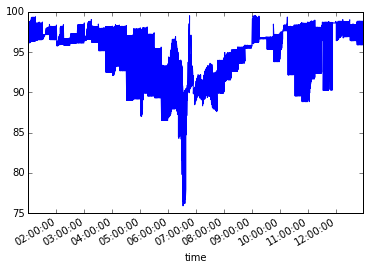

In [341]:
#D_mem1=D_mem
#D_mem1 = D_mem1.set_index('time')
D_mem1['memused'] = D_mem1['memused'].apply(float) 
pd.Series(D_mem1.memused).plot()

In [259]:
for d in D:
                
        if d.split()[0]=='Average:':
                    G=get_values_av(d.split(), dv, dk[1:])
                    if D_av_cpu.shape[0]==0:
                        D_av_cpu=pd.DataFrame([G], columns=dk)
                    else:
                        D_av_cpu=pd.DataFrame([G], columns=dk)
                G=get_values(d.split(), dv, dk[1:])
                    #print (G)
                if D_cpu.shape[0]==0 and G:
                    D_cpu=pd.DataFrame([G], columns=dk)
                elif G:
                    D_cpu=D_cpu.append(pd.DataFrame([G], columns=dk), ignore_index=True)

['11:39:01 PM     CPU      %usr     %nice      %sys   %iowait    %steal      %irq     %soft    %guest     %idle',
 '11:40:01 PM     all      0.21      0.00      0.21      0.00      0.00      0.00      0.00      0.00     99.58',
 '11:40:01 PM       0      0.25      0.00      0.23      0.00      0.00      0.00      0.00      0.00     99.52',
 '11:40:01 PM       1      0.28      0.00      0.22      0.00      0.02      0.00      0.00      0.00     99.48',
 '11:40:01 PM       2      0.15      0.00      0.23      0.00      0.00      0.00      0.00      0.00     99.62',
 '11:40:01 PM       3      0.20      0.00      0.17      0.00      0.00      0.00      0.00      0.00     99.63',
 '11:40:01 PM       4      0.32      0.00      0.22      0.00      0.00      0.00      0.00      0.00     99.47',
 '11:40:01 PM       5      0.12      0.00      0.17      0.00      0.00      0.00      0.00      0.00     99.72',
 '11:41:01 PM     all      1.11      0.00      1.06      0.00      0.01      0.00      0

In [188]:
part_first_line=cpu_usage.split('\n')[0]
part_parts = part_first_line.split()

AttributeError: 'list' object has no attribute 'split'

In [85]:
part_parts

['12:00:01',
 'AM',
 'CPU',
 '%usr',
 '%nice',
 '%sys',
 '%iowait',
 '%steal',
 '%irq',
 '%soft',
 '%guest',
 '%idle']

In [86]:
#self.__find_column(FIELDS_CPU, first_line)
#part_parts = part_first_line.split()
return_dict={}
counter=0
for piece in part_parts:
            for colname in FIELDS_CPU:
                pattern_re = re.compile(colname)
                if (pattern_re.search(piece)):
                    return_dict[colname] = counter
                    break
            counter += 1

print(return_dict)

for colver in FIELDS_CPU:
            try:
                tempval = return_dict[colver]
                del(tempval)
            except KeyError:
                return_dict[colver] = None
                
print(return_dict)

{'\\%sys': 5, '\\%(usr|user)': 3, '\\%idle': 11, '\\%nice': 4, '\\%iowait': 6}
{'\\%sys': 5, '\\%(usr|user)': 3, '\\%idle': 11, '\\%nice': 4, '\\%iowait': 6}


In [117]:
import pandas as pd
def get_values(s, ld):
    fd=[]
    for i in ld:
        #print(s[i])
        fd.append(s[i])#=[fd+s[i]]
    return (fd)
    


dv=list(return_dict.values())
dk=list(return_dict.keys())
#print(ld)
S=cpu_usage.split('\n')
D=pd.DataFrame()
print(str(dk))
pattern_cpu='.*sys.*(usr|user).*idle.*nice.*sys.*iowait.*soft.*idle'
pattern_re = re.compile(PATTERN_CPU)
for s in S:
    print(s.split())
    gv=get_values(s.split(), dv)
    print (''.join(gv))
    print(PATTERN_CPU)
    print(pattern_re.search(''.join(gv)))
    if D.shape[0]==0 and pattern_re.search(''.join(gv)):
        D=pa.DataFrame(gv, index=dk)
    elif gv==dk:
        continue
    else:
        D=D.append(gv, index=dk)
   

['\\%sys', '\\%(usr|user)', '\\%idle', '\\%nice', '\\%iowait']
['12:00:01', 'AM', 'CPU', '%usr', '%nice', '%sys', '%iowait', '%steal', '%irq', '%soft', '%guest', '%idle']
%sys%usr%idle%nice%iowait
.*CPU.*(usr|user).*nice.*sys.*
None


TypeError: append() got an unexpected keyword argument 'index'

In [107]:
dictn={}
for i in range(len(ld)):
    dictn={ld[i]:gv[i]}
    print(dictn)

{5: '%sys'}
{3: '%usr'}
{11: '%idle'}
{4: '%nice'}
{6: '%iowait'}


In [74]:
part_parts[[4,5]]

TypeError: list indices must be integers or slices, not list

In [57]:
return_dict.keys()

value = elems[fields[pairs[sectionname]]]

TypeError: 'dict_keys' object does not support indexing

In [67]:
part_type=PART_CPU
pattern = ''

if (part_type == PART_CPU):
    pattern = PATTERN_CPU
elif (part_type == PART_MEM):
    pattern = PATTERN_MEM
elif (part_type == PART_SWP):
    pattern = PATTERN_SWP
elif (part_type == PART_IO):
    pattern = PATTERN_IO
return_dict = {}

pattern_re = re.compile(pattern)

In [70]:
for part_line in cpu_usage.split("\n"):
    pattern = ''

    if (part_line.strip() != '') and \
            not pattern_re.search(part_line):

                # Take care of AM/PM timestamps in SAR file
            is_24hr = True
            is_AM = False

    if part_line[9:11] == 'AM':
            is_24hr = False
            is_AM = True
    elif part_line[9:11] == 'PM':
            is_24hr = False
            is_AM = False

    if is_24hr is False:
            part_line =  ('%s_%s XX %s' % (part_line[:8], part_line[9:11], part_line[12:]))

                # Line is not empty, nor it's header.
                # let's hit the road Jack!
            elems = part_line.split()
            full_time = elems[0].strip()

            if (full_time != "Average:"):

                    # Convert time to 24hr format if needed
                if is_24hr is False:
                    full_time = full_time[:-3]

                        # 12 is a bitch in AM/PM notation
                    if full_time[:2] == '12':
                        if is_AM is True:
                            full_time = ('%s:%s' % ('00', full_time[3:]))
                        is_AM = not is_AM

                    if is_AM is False and full_time[0:2] != '00':
                        hours = int(full_time[:2]) + 12
                        hours = ('%02d' % (hours,))
                        full_time = ('%s:%s' % (hours, full_time[3:]))

                try:
                    blah = return_dict[full_time]
                    del(blah)
                except KeyError:
                    return_dict[full_time] = {}

                    # Common assigner
                fields = None
                pairs = None
                if part_type == PART_CPU:
                    fields = return_dict
                    pairs = FIELD_PAIRS_CPU

                for sectionname in pairs.keys().iterkeys():

                    value = elems[fields[pairs[sectionname]]]

                    if sectionname == 'membuffer' or \
                            sectionname == 'memcache' or \
                            sectionname == 'memfree' or \
                            sectionname == 'memused' or \
                            sectionname == 'swapfree' or \
                            sectionname == 'swapused':
                        value = int(value)
                    else:
                        value = float(value)

                    if part_type == PART_CPU:
                        cpuid = elems[(1 if is_24hr is True else 2)]
                        try:
                            blah = return_dict[full_time][cpuid]
                            del(blah)
                        except KeyError:
                            return_dict[full_time][cpuid] = {}
                        return_dict[full_time][cpuid][sectionname] = \
                            value
                    else:
                        return_dict[full_time][sectionname] = value


KeyError: '\\%idle'

In [114]:
PATTERN_CPU

'.*CPU.*(usr|user).*nice.*sys.*'